In [1]:
# load modules 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
#input raw data
raw_data = pd.read_json('food_enforcement_US_bacteria.json', orient='records')

In [3]:
print(raw_data.shape)
print(raw_data.head(10).product_description)

(6104, 26)
0    Native Catch Salmon Bacon, Traditional flavor....
1    Delish Fruit Burst 10 oz.(283 g)  Enjoy by: 8/...
2    Garden Pure Holiday Fruit Bowl 4 lbs (1.81kg) ...
3    Fresh Fruit Product is labeled in part:  "***F...
4    Ready Pac¿ Gourmet Fruit Bowl, 64oz , UPC 7774...
5    River Ranch brand Diced Grn Cabbage w/Color, 4...
6    Sweet and Sour Stir Fry packaged under the fol...
7    Onion Slab Cut.  Products are labeled in part:...
8    MIX w/yellow onions used as an ingredient.  Pr...
9    Fresh n Easy brand Shred Grn Cabbage w/Color, ...
Name: product_description, dtype: object


### Clean and lemmatize text + TF-IDF vectorize

In [4]:
# class objects
stops = stopwords.words('english')
tfidf = TfidfVectorizer(stop_words = 'english', max_features = 20000)
lemmer = WordNetLemmatizer()

In [38]:
# add stop words after analysis 
stops.extend(('oz', 'upc', 'lb', 'bag', 'package', 'net', 'upc', 'gallon', 'pint', 'ml', 'wei', 'plastic','inc', 'b', 
              'com', 'code', 'department', 'wt', 'number', 'industry', 'ia', 'irwindale', 'usa', 'earlier', 'wei',
             'quart', 'august', 'mamaroneck', 'food', 'imp', 'gl', 'sff', 'description', 'gram', 'weight', 
             'brand', 'label', 'fc', 'ounce', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 
              'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh',
              'nj', 'ny', 'nm', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va',
              'wa', 'wv', 'wi', 'wy', 'item', 'pkgs', 'distribute', 'brooklyn', 'lb', 'jefferson', 'dist', 'com', 'c',
              'beaverton', 'retail', 'determine', 'unable', 'sell', 'snoqualmie', 'gc', 'unit', 'seattle', 'albertson', 
              'kg','cambridge', 'warrensburg', 'op', 'lg', 'rom', 'bentonville', 'chapel', 'hill', 'swainsboro', 'lb',
              'www', 'iff', 'wei', 'aurora', 'harris', 'bi', 'lo', 'gal', 'qts', 'gh', 'llc','springfield', 'label', 'x',
              'kg', 'po', 'al', 'birmingham','princeton','dz', 'institutional','mb','pleasanton','wei','richfield', 'g', 'per'
             ))

In [39]:
# Define function get_pos
# Map POS tag to first character lemmatize() accepts

def get_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

In [40]:
# Define function kleenex
# Cleans, lemmatizes, and removes stop words 

def kleenex(d):
    tmp = []
    for t in d:
        if type(t) == str:
            w = re.sub("[^A-Za-z]+", " ", t) # remove non-letters
            w = w.lower() # lower class
            w = w.strip() # remove spaces
            w = word_tokenize(w) # tokenize words
            w = [lemmer.lemmatize(wrd, get_pos(wrd)) for wrd in w if wrd not in stops] #lemmatize word
            w = " ".join(w)
            tmp.append(w)
        #else:
        #    tmp.append(None)
    return(tmp)

In [41]:
# Build corpus
corpus = raw_data['product_description']

# Clean Corpus
X = kleenex(corpus)

In [42]:
# TF-IDF transformation
Xtrans = tfidf.fit_transform(X)

# get tf idf feature names 
words = tfidf.get_feature_names()

# tf-idf shape
Xtrans.shape


(6104, 5201)

### fit Kmeans and find optimal number of clusters

In [43]:
# fitting K means to view change in Inertia
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# container to store inertia scores over iterations
distortions = []
NCs = (10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200)
km = {}
silhouette_coef = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(20):
    km[i] = KMeans(n_clusters=NCs[i], n_init=20)
    km[i].fit(Xtrans)
    distortions.append(km[i].inertia_)
    score = silhouette_score(Xtrans, km[i].labels_)
    silhouette_coef.append(score) 

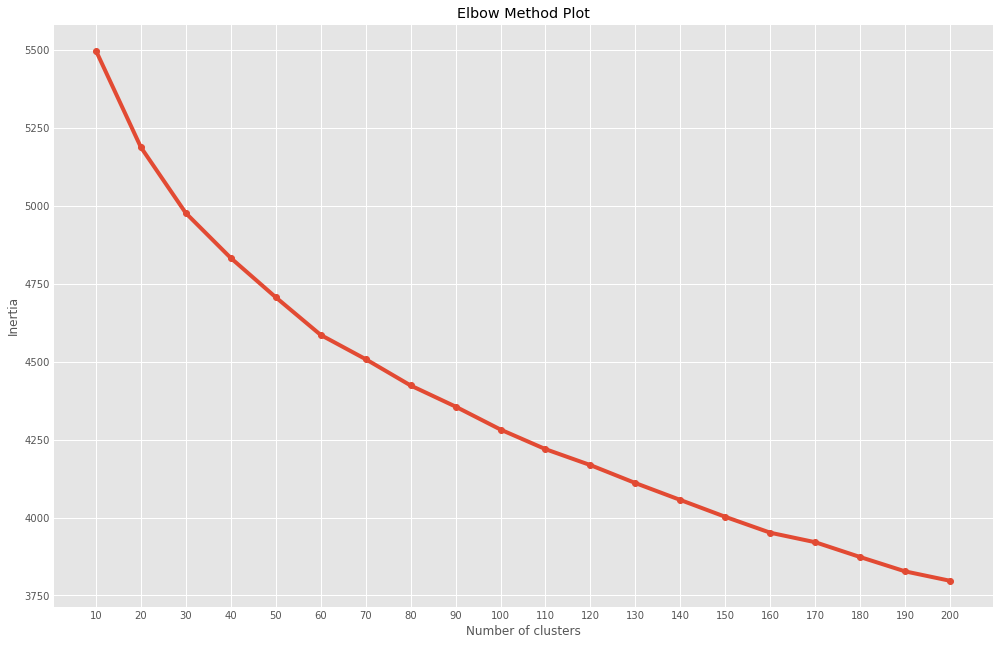

In [44]:
# vizualize change in inertia
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.plot(range(20), distortions, marker='o')
plt.title('Elbow Method Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(20), NCs)
plt.show()

In [45]:
# locate the elbow

from kneed import KneeLocator

kl = KneeLocator(NCs, distortions, curve="convex", direction="decreasing")

kl.elbow


60

### Plot Silhouette score

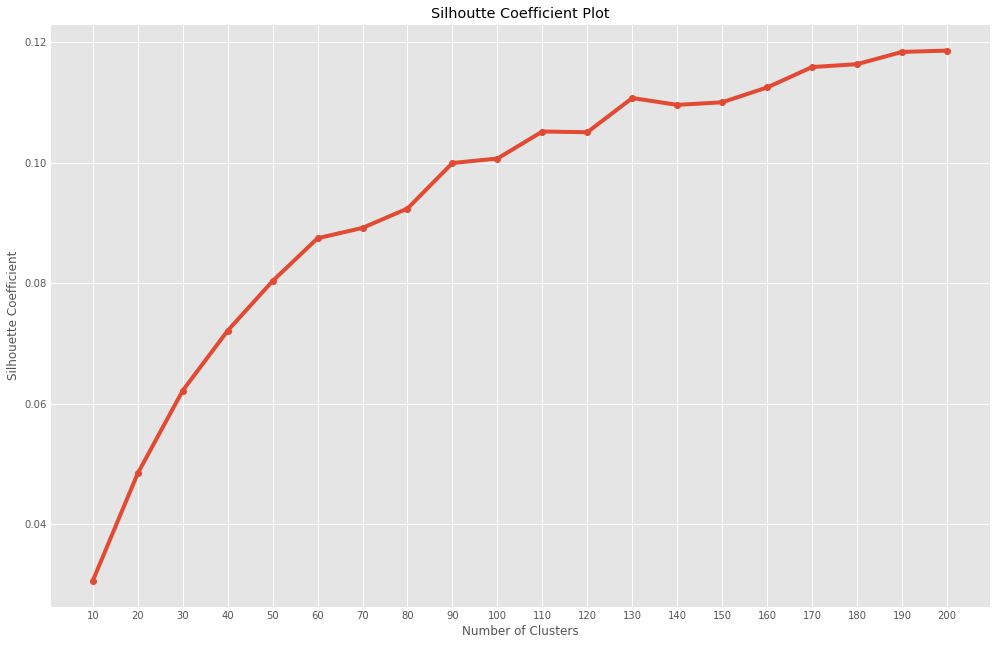

In [46]:

plt.figure(figsize=(15,10))

plt.plot(range(20), silhouette_coef, marker='o')
plt.title('Silhoutte Coefficient Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.xticks(range(20), NCs)
plt.show()


### labels are named with integers and stored in the `labels_` attribute

In [47]:
km[12].labels_

array([17, 18, 62, ..., 72, 85, 85])

### take a look at one of the cluster results

In [49]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

n=12
cluster=54

for i in range(0,len(km[n].labels_)):
    if km[n].labels_[i] == cluster:
        print(raw_data['product_description'][i])
        print('**********')

Tumulo Farms, Pondhopper Cheese; any cut or partial wheels, wrapped in cheese paper with with type of cheese marked with magic marker and a Tomales Bay Foods sticker applied.  Product is cut and packaged by Tomales Bay Foods, Petaluma, CA   
**********
Shepherd's Way Big Woods Blue cut wrapped in cheese paper with with type of cheese marked with magic marker and a Tomales Bay Foods sticker applied.    Product is cut and packaged by Tomales Bay Foods, Petaluma, CA   
**********
Homestead Creamery Artisan Cheese, Flory's Favorite, whole raw jersey milk, packaged in 1-lb or 1/2-lb block/plastic packs.
**********
Panela, Latin Style Soft Cheese, packaged in plastic wrap, Net Wt. 1 lb.  The UPC is  6 10074 99341 4
**********
Chocolate Butter Luv ice cream; Pint containers.  Product is labeled in part, "***brain freeze creamery***Manufactured by Brain Freeze Creamery, Spokane, WA  www.brainfreezecreamery.com***"    
**********
Vanilla Butter Luv ice cream; Gallon and pint containers.  Produc

### Examine top 10 common words by cluster

In [50]:
# Set the top 10 common words in K Means cluster centers 
common_words = km[12].cluster_centers_.argsort()[:,-1:-11:-1]

# print out the results by the 250 clusters 
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : shell, sunland, clam, peanut, raw, bulk, sprout, walnut, case, hazelnut
1 : dough, bell, blue, krazy, cookie, kookie, chip, ice, cream, chocolate
2 : garden, fresh, salad, kit, product, seafood, mousse, bean, tuna, dessert
3 : affixed, flavor, bulk, date, container, label, ice, cream, product, sorbet
4 : sell, sorbet, tub, product, lemon, pomegranate, tray, pear, champagne, lime
5 : parker, lid, snap, brand, follow, farm, size, sell, pail, cheese
6 : easy, neighborhood, segundo, el, white, fresh, write, produce, print, market
7 : grocer, vitamin, natural, associate, pudding, cottage, wholesale, instant, pie, distribute
8 : macaroni, salad, amish, wei, product, fresh, case, container, meijer, reser
9 : cream, ice, gum, husky, milk, half, bulk, lecithin, skim, carrageenan
10 : carrot, pepper, fry, stir, vegetable, broccoli, ingredient, statement, onion, pea
11 : tradition, fine, salad, pasta, potato, product, southwest, dip, cheese, cheddar
12 : herring, eat, ready, seafood, refriger

### Plot histogram to see distribution by labels 

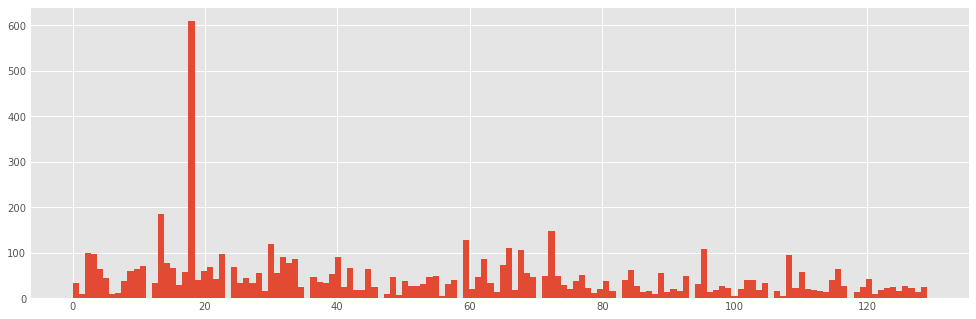

In [51]:
plt.figure(figsize=(15,5))

plt.hist(km[12].labels_, density=False, bins=140)
plt.show()

# Summary of Work and Results using K Means Clustering

### Data cleaning and Initial Clustering 

I first carried out data cleaning of the text by removing stop-words, non-letters and spaces, lower-case trasnforming, tokenizing and then lemmatizing the words for analysis. The corpus was then analyzed with the TFIDFVectorizer from scikit learn. With these features, I carried out KMeans clustering with number of clusters from 2 to up to 400. The result showed that there were no clear elbow in the inertia plot where the inertia rates continue to gradually decrease with the increase in number of clusters. However, with more clusters, the clustering becomes inefficient and impractical for use. 

After the first pass, I also recongized that there were a number of words that were common but not specifically relevant for the clustering by food categories. These included weight figures such as 'oz', 'lbs' or location and state names and others. Hence, I added these to the stop-word list to remove in the data cleaning stage. 

### KMeans cluster optimization

As for the number of clusters, I decided to find the optimum value from 10 to 200 to make the clusters practical. To check the results, I used the Elbow Plot and Silhoutte Scores to find the optimum number. Based on the KneeLocator, the knee is suggested at 60, which is a managable number of food categories. The clustering result is also quite good with most clusters having coherent grouping of similar food categories. However, there seems to be a cluster that contains a number of non-classified items which is quite large with over 1,500 items. Considering this is almost 25% of the total number of items, I was not fully satisified with 60 clusters. 

Using the silhoutte coefficient plot, I look at the consistency of the clusters. The plot shows that the silhoutte scores continue to improve overall with the number of clusters up. However, it seems to plateau at around 130 clusters. This also seems to be a more practical number compared to 200 clusters that has a higher silhoutte coefficient, but more clusters to analyze. Hence, I decided to use 130 clusters with n_init=20 for the final KMeans model. 

### Clustering Results and Examples

The clustering using the final model works well with all most all clusters that have cohesive food categories within the clusters. Howver, there does seem to be some overlap between clusters as suggested by the relatively low silhoutte coefficient. For instance, there are a number of ice cream and salads clusters, although slightly different by type, product or company, as seen in the top 10 common words per cluster analysis. Other than this, there also continues to be a left-over cluster, where non-classifiable items are dumpped. However, the size the cluster has decreased to around 600 items or so. Looking at the items for this cluster, there does seem to be difficulties in clusters considering that they tend to have very short descriptions and use vague language that are difficult to associate with other clusters. 



# Thematic Extraction Using Gensim LDA

In [52]:
# Gensim
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim

#Data Viz
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [53]:
# Thematic extraction prep
x_token = list()

for word in X:
    x_token.append(word.split(" "))

In [61]:
# Thematic extraction
First = corpora.Dictionary(x_token)
corp = [First.doc2bow(text) for text in x_token]

ldamod = gensim.models.ldamodel.LdaModel(corp, num_topics = 30, id2word = First, passes = 45)
First_topics = ldamod.print_topics(num_words = 5)

print("Product recall topics")
for topic in First_topics:
    print(topic)

Product recall topics
(5, '0.179*"pack" + 0.092*"variety" + 0.035*"price" + 0.034*"cheddar" + 0.027*"follow"')
(12, '0.218*"vegetable" + 0.104*"product" + 0.077*"include" + 0.069*"dip" + 0.068*"mixed"')
(23, '0.116*"onion" + 0.053*"pepper" + 0.052*"season" + 0.049*"r" + 0.044*"yellow"')
(19, '0.148*"cauliflower" + 0.098*"corn" + 0.089*"use" + 0.050*"cut" + 0.037*"chipotle"')
(24, '0.137*"pepper" + 0.123*"red" + 0.117*"hummus" + 0.099*"veggie" + 0.084*"garlic"')
(17, '0.108*"case" + 0.083*"carton" + 0.074*"package" + 0.053*"salad" + 0.053*"reser"')
(15, '0.044*"milk" + 0.037*"gum" + 0.035*"powder" + 0.031*"soy" + 0.031*"sugar"')
(6, '0.101*"floret" + 0.090*"broccoli" + 0.083*"fresh" + 0.081*"food" + 0.066*"frozen"')
(3, '0.137*"bean" + 0.128*"green" + 0.095*"pea" + 0.067*"carrot" + 0.057*"mesh"')
(14, '0.091*"butter" + 0.083*"peanut" + 0.052*"bell" + 0.041*"blue" + 0.031*"white"')
(29, '0.227*"cheese" + 0.060*"salad" + 0.056*"pasta" + 0.054*"fine" + 0.053*"tradition"')
(26, '0.193*"froz

In [57]:
# Data Viz
vis = pyLDAvis.gensim.prepare(ldamod, corp, dictionary=ldamod.id2word)
pyLDAvis.display(vis)

In [65]:
# dominant topics for each entry


def format_topics_sentences(ldamodel=None, corpus=corp, texts=x_token):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_keywords = format_topics_sentences(ldamodel=ldamod, corpus=corp, texts=X)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.3595,"bag, box, individual, case, poly, lb, cut, cat...",native catch salmon bacon traditional flavor t...
1,1,5.0,0.6092,"pack, variety, price, cheddar, follow, street,...",delish fruit burst enjoy distribute walgreen w...
2,2,20.0,0.2881,"scale, cake, make, five, dec, last, digit, pub...",garden pure holiday fruit bowl lb best f produ...
3,3,8.0,0.4101,"mix, fruit, snack, favorite, mango, baby, sing...",fresh fruit product label part fresh island me...
4,4,25.0,0.3792,"date, label, product, best, ready, bulk, part,...",ready pac gourmet fruit bowl use date
5,5,7.0,0.6039,"ranch, product, river, polyethylene, n, basket...",river ranch dice grn cabbage w color n product...
6,6,13.0,0.7891,"sweet, brand, trader, joe, sauce, spicy, packa...",sweet sour stir fry package follow name size g...
7,7,23.0,0.6358,"onion, pepper, season, r, yellow, stir, fry, c...",onion slab cut product label part onion yellow...
8,8,8.0,0.2772,"mix, fruit, snack, favorite, mango, baby, sing...",mix w yellow onion use ingredient product may ...
9,9,7.0,0.5650,"ranch, product, river, polyethylene, n, basket...",fresh n easy shred grn cabbage w color n produ...


In [75]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

topic=2

for i in range(0,len(df_dominant_topic.Dominant_Topic)):
    if df_dominant_topic.Dominant_Topic[i] == topic:
        print(raw_data['product_description'][i])
        print('**********')

Organic traditions SPROUTED CHIA & FLAX SEED POWDER, NET WT. 8 oz./227g (UPC barcode 854260006216), and NET WT. 16oz./454g bag (UPC barcode 85426000547) --- The product is packed in a sealed flexible plastic bag.
**********
Cilantro, 2.5 dozens, 30 bunches/case
**********
Flavored cheddar cheese, vacuum packed in weights ranging from 0.25-0.50 pounds, labeled and batch coded by firm.  Cheese labeled in part:  "Medium Cheddar Red Pepper with Onion & Garlic Pasteurized whole milk, salt, culture, vegetable rennet, spices.  r-BST free.***GOLDEN GLEN CREAMERY 15098 Field Road  Bow, WA 98232***887"
**********
Macadamia Nuts  Style 2, RAW, SHELLED.    DESCRIPTION OF CARTON FROM GUATEMALA:    LOT 2 70 JUNE 25/12 423, 43 1 NORMAL/BIG . 				  		
**********
#338 Tortellini Primavera		5 pounds  
**********
#356 Tuna Spread	5 pounds  
**********
Pound Cake		12 ounces  
**********
#330 Neptune Salad	5 pounds  
**********
#311 Fruit & Nut Wild Rice Salad	311	5 pounds  
**********
Daniella Mangoes  Ma

Country Gardens Cuisine, Singles, Broccoli Cheese Soup with Rice, Net Wt. 1.25 oz (35 grams)
**********
Sabra Hummus Pine Nut, 7 OZ, 10 OZ, 17 OZ, 32 OZ    UPC                      SKU                   ITEM    040822011747    300132               Sabra Hummus Pine Nut 10OZ    040822127530    300134               Sabra Hummus Pine Nut 7OZ    040822990011    300136               Sabra Hummus Pine Nut 17OZ    040822012157    300139               Sabra Hummus Pine Nut 32OZ    040822990011    300501               Sabra Hummus Pine Nut 17OZ
**********
Cold Stone Creamery RTE Cookie Dough Puck 2505, NET WT. 22.5 lb (10.215 kg), Aspen Hills, Inc. 
**********
Snickerdoodle Cookie Dough 1041197 NET WT. 30 lb (13.61 kg), Aspen Hills, Inc. Garner, IA 50438 
**********
Super Nacho (No-Pho, Gluten Free). Product Code: T4034. 50 lb bags.                            
**********
Sabra Spreads Honey Mustard, 8.5OZ; UPC 040822343121; SKU301587 
**********
CCF Butter Popcorn Seasoning, NET Wt. 1000 lbs, G

# Summary of Work using Gensim LDA method 

Considering the effectiveness of their models, I carried out topical modeling of the corpus using gensim Latent Dirichlet allocation (LDA). Considering the difficulties with working with a large number of topics, I kept the number of topics at 30 to make it managable. The LDA method does seem to pick up on the main topic areas for the recalled food products, when looking at the distribution plot using pyLDAvis. For instance, you see a strong cluster around 'ice creams', another large cluster around 'salads', as well as clusters around 'cheese', 'butter' and 'vegetables'. These clusters do seem to provide some room for allocating the products into more sizable "topical" clusters. 

However, when trying to identify the dominant topics and using that for clustering, the result does not seem to fit as well as the K Means clustering. This especially seems to be the case for text that are only loosely associated to a certain dominant topic. While LDA is strong in identifying the underlying topic clusters throughout the corpus, there seem to be at least some limitation in using it for food product categorization at least based on my experimentation of the method. 

Hence, if I had to select, I would prefer using the K Means method to identify the clusters even if there are limits in having a left-over cluster. 
